In [ ]:
import math
import numpy as np
#drag estimation for each flight phase 
# Constants
rho0 = 1.225  # Sea level air density (kg/m^3)
h = [0, 5000, 12500, 30]  # Altitudes in meters (takeoff, climb, cruise, landing)
Cd0 = 0.02 # Parasitic drag coefficient 
delta = 0.005  # Induced drag correction factor
AR = 1.8 # Aspect ratio
CL = [1, 0.6, 0.261, 1.5]  # Lift coefficients for phases 
S = 164.9  # Wing area (m^2)
W = 471511.32  # Aircraft weight (N)
gamma = 6  # Climb angle in degrees
v = [68, 80, 290, 56]  # Speeds (m/s) for each phase

# Drag coefficients
Cd = np.array([Cd0 + ((cl ** 2) / (math.pi * AR)) * (1 + delta) for cl in CL])
cd = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, cd in enumerate(cd):
    print(f"{cd} Cd: {Cd[i]:.2f} ")

# Density function
def rho(h):
    rho0 = 1.225
    sea_level_temp = 288.15
    lapse_rate = -0.0065
    R = 287.05
    g = 9.80665
    tropopause_height = 11000

    if isinstance(h, (list, np.ndarray)):
        return np.array([rho(alt) for alt in h])
    if h <= tropopause_height:
        temperature = sea_level_temp + lapse_rate * h
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R))
    else:
        temperature = sea_level_temp + lapse_rate * tropopause_height
        exp_factor = (-g * (h - tropopause_height)) / (R * temperature)
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R)) * math.exp(exp_factor)

# Dynamic pressure calculation
def dynamic_pressure(V, h):
    densities = rho(h)
    return 0.5 * densities * np.array(V)**2

# Thrust required 
def thrust_required(Cd, q, S):
    return Cd * q * S

# Additional thrust for climb
def thrust_required_climb(W, gamma):
    gamma_rad = math.radians(gamma)
    return W * math.sin(gamma_rad)

# thrust calculations for each segements  
q = dynamic_pressure(v, h)  # Dynamic pressure for each segements 
T = [thrust_required(Cd[i], q[i], S) for i in range(len(v))]
T[1] += thrust_required_climb(W, gamma)  # Add climb-specific thrust

#  segment Results
segments = ["Takeoff", "Climb", "Cruise", "Landing"]
print("Dynamic Pressures for each segments:")
for i, segments in enumerate(segments):
    print(f"{segments}: {q[i]:.2f} Pa")

segments = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, segments in enumerate(segments):
    print(f"{segments} thrust: {T[i]:.2f} N")


Takeoff Cd: 0.23 
Climb Cd: 0.10 
Cruise Cd: 0.03 
Landing Cd: 0.50 
Dynamic Pressures for each segments:
Takeoff: 2832.20 Pa
Climb: 2089.88 Pa
Cruise: 9081.90 Pa
Landing: 1913.98 Pa
Takeoff thrust: 108942.93 N
Climb thrust: 82637.46 N
Cruise thrust: 51709.33 N
Landing thrust: 157760.81 N


In [ ]:
#thrust specific fuel consumption for each flight phase 
TSFC_static = 0.00014  # kg/N/s (static TSFC) of Rolls Royce ultrafan 
altitude_corrections = [1.0, 0.95, 0.9, 1.0]  # Takeoff, climb, cruise, landing
mach_corrections = [1.0, 0.9, 0.85, 1.0]  # Takeoff, climb, cruise, landing
thrusts = [247819.25, 115180.38, 53957.28, 13119.94]  # Total thrust (N) for each flight segment 
durations = [120, 900, 18000, 60]  # Seconds for each flight segments

# Calculate TSFC and fuel consumption
fuel_burn = []
for i in range(len(thrusts)):
    TSFC = TSFC_static * altitude_corrections[i] * mach_corrections[i]
    fuel_rate = TSFC * thrusts[i]  # kg/s
    fuel_burn_phase = fuel_rate * durations[i]  # kg
    fuel_burn.append(fuel_burn_phase)

# Results
phases = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, phase in enumerate(phases):
    print(f"{phase}:")
    print(f"  TSFC: {TSFC_static * altitude_corrections[i] * mach_corrections[i]:.6f} kg/N/s")
    print(f"  Fuel Burn: {fuel_burn[i]:.2f} kg")








Takeoff:
  TSFC: 0.000140 kg/N/s
  Fuel Burn: 4163.36 kg
Climb:
  TSFC: 0.000120 kg/N/s
  Fuel Burn: 12408.38 kg
Cruise:
  TSFC: 0.000107 kg/N/s
  Fuel Burn: 104018.84 kg
Landing:
  TSFC: 0.000140 kg/N/s
  Fuel Burn: 110.21 kg


Takeoff: 247819.25 N (total for 2 engines)
Climb: 115180.38 N (total for 2 engines)
Cruise: 53957.28 N (total for 2 engines)
Landing: 13119.94 N (total for 2 engines)


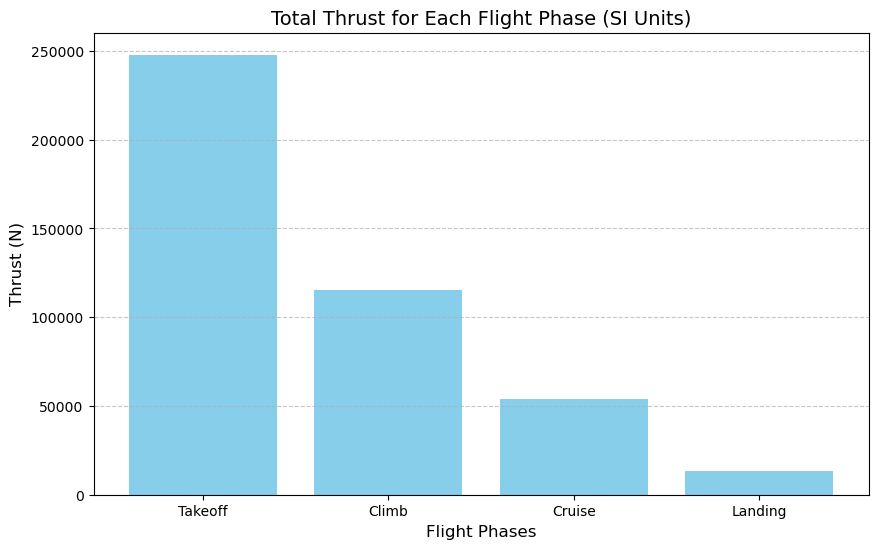

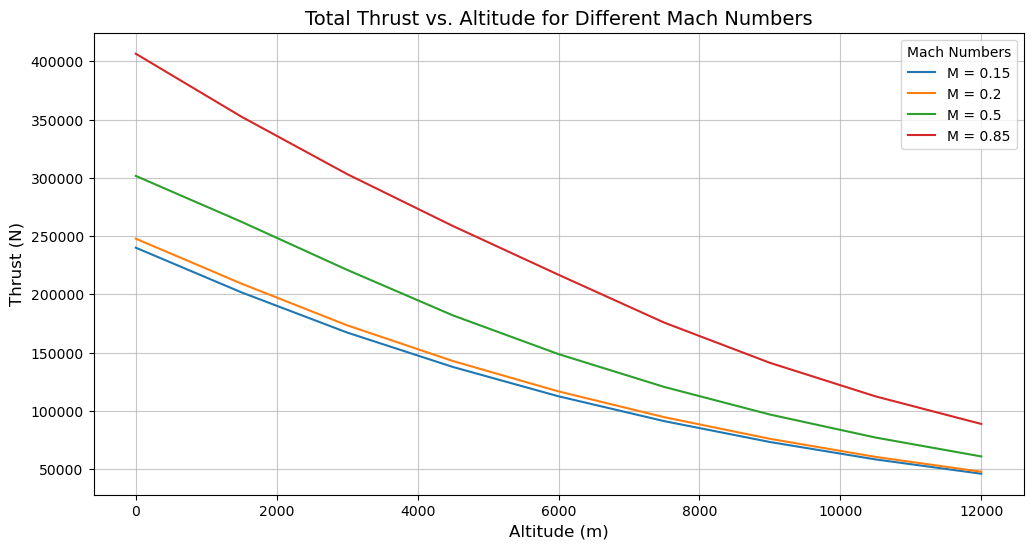

In [35]:
import math
import matplotlib.pyplot as plt

def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine based on altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = T0 - 0.0065 * 11000 + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R)) * math.exp(
            -9.80665 * (H - 11000) / (R * T)
        )
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = P / P0 * (1 + 0.2 * M ** 2) ** 3.5
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # High Bypass Ratio Turbofan Calculation
    if theta <= TR:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M) - 3 * (theta - TR) / (1.5 + M))
    
    return thrust

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.2, "TR": 1.0, "deltaOAT_C": 0}, #TR 0.9-1 because full power is required at takeoff
    "Climb": {"H": 5000, "M": 0.3, "TR": 0.8, "deltaOAT_C": -5}, # TR 0.75-0.85 because moderate power is required at climb
    "Cruise": {"H": 12500, "M": 0.9, "TR": 0.6, "deltaOAT_C": -10},#TR 0.5-0.7 because low power is required at cruise 
    "Landing": {"H": 0, "M": 0.15, "TR": 0.4, "deltaOAT_C": 5}, # TR 0.3-0.5 because very low  power is required to decent 
}

# Constants
F0 = 100000 # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

# Visualization: Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization: Thrust vs. Altitude and Mach Number
altitudes = range(0, 12500, 1500)  # Altitudes from 0 to 11,000 m
mach_numbers = [0.15, 0.2, 0.5, 0.85]  # Example Mach numbers (Landing, Takeoff, Climb, Cruise)

plt.figure(figsize=(12, 6))
for M in mach_numbers:
    thrusts = [
        high_bypass_turbofan_thrust(F0, 1.0, H, M, 0) * num_engines for H in altitudes
    ]
    plt.plot(altitudes, thrusts, label=f"M = {M}")

plt.title("Total Thrust vs. Altitude for Different Mach Numbers", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Altitude (m)", fontsize=12)
plt.legend(title="Mach Numbers", fontsize=10)
plt.grid(alpha=0.7)
plt.show()


Mission: Passenger
Takeoff Thrust: 113828.41 N
Climb Thrust: 154825.52 N
Cruise Thrust: 56258.21 N
Landing Thrust: 181802.25 N
Mission: Aspen
Takeoff Thrust: 98147.96 N
Climb Thrust: 168816.91 N
Cruise Thrust: 35801.06 N
Landing Thrust: 152764.39 N
Mission: Napa
Takeoff Thrust: 130670.37 N
Climb Thrust: 230555.95 N
Cruise Thrust: 45534.47 N
Landing Thrust: 247453.06 N


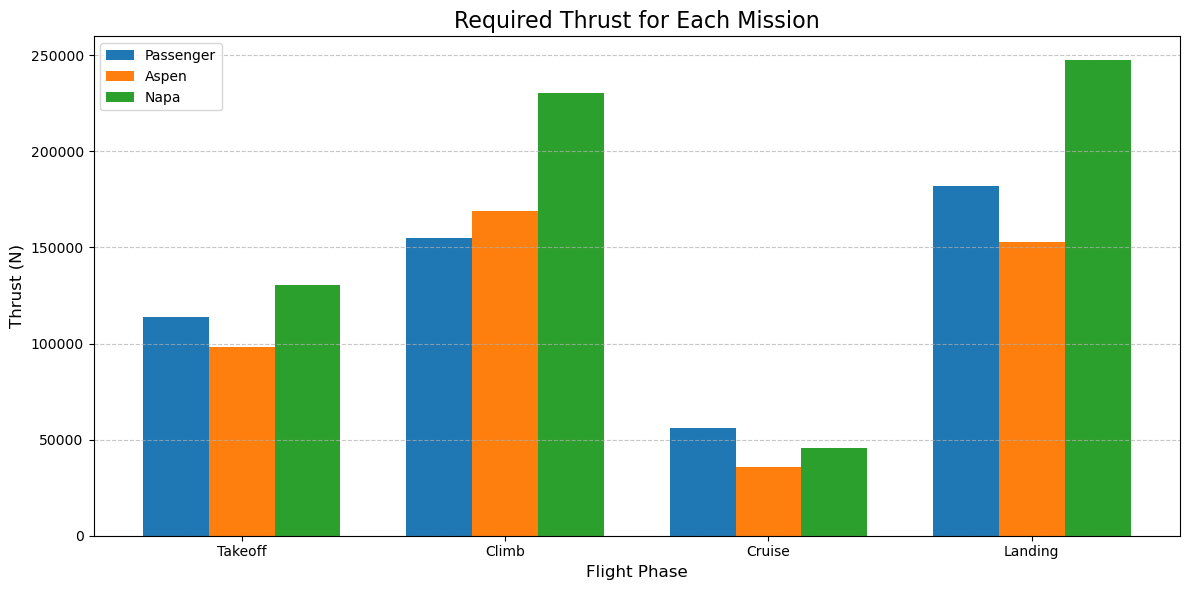

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
#performance analysis at different airports with respect to the given missions 
# Constants
rho_sl = 1.225  # Air density at sea level (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)
conversion_factor = 0.3048  # ft to m conversion

# Inputs (to be replaced with specific mission data)
wing_area = 164.9  # Wing area (m²)
Cl = [1, 0.6, 0.261, 1.5]  # CL for takeoff, climb, cruise, landing
Cd = [0.23, 0.10, 0.03, 0.50]  # CD for takeoff, climb, cruise, landing
gamma_climb = 6  # Climb angle in degrees

# Mission-specific weights (in Newtons)
weights = {
    "Passenger": 471511.32,  # Actual MTOW for Mission 1
    "Aspen": 411444.0,  # MTOW for Mission 2
    "Napa": 500000.0,  # MTOW for Mission 3
}

# Mission-specific altitudes and speeds (m and m/s)
missions = {
    "Passenger": {"altitude": [0, 5000, 12500, 0], "speeds": [70, 140, 250, 60]},
    "Aspen": {"altitude": [0, 2500, 11000, 0], "speeds": [65, 130, 230, 55]},
    "Napa": {"altitude": [0, 2000, 10000, 0], "speeds": [75, 150, 240, 70]},
}

# Phases
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Functions
def air_density(h):
    """ISA atmosphere model for air density."""
    if h <= 11000:
        return rho_sl * (1 - 0.0065 * h / 288.15) ** 5.256
    else:
        return 0.36391  # Approximation above 11 km

def dynamic_pressure(rho, V):
    return 0.5 * rho * V**2

def thrust_required(CD, q, S):
    return CD * q * S

def climb_thrust(weight, gamma_deg):
    gamma_rad = math.radians(gamma_deg)
    return weight * math.sin(gamma_rad)

# Store thrust results for visualization
thrust_results = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"Mission: {mission}")
    W = weights[mission]
    altitudes = data["altitude"]
    speeds = data["speeds"]

    for i, phase in enumerate(phases):
        rho = air_density(altitudes[i])
        q = dynamic_pressure(rho, speeds[i])
        T_drag = thrust_required(Cd[i], q, wing_area)
        if phase == "Climb":
            T = T_drag + climb_thrust(W, gamma_climb)
        else:
            T = T_drag
        thrust_results[mission].append(T)
        print(f"{phase} Thrust: {T:.2f} N")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot each mission's thrust for all phases
for i, mission in enumerate(missions):
    ax.bar(x + i * width, thrust_results[mission], width, label=mission)

# Customization
ax.set_title("Required Thrust for Each Mission", fontsize=16)
ax.set_xlabel("Flight Phase", fontsize=12)
ax.set_ylabel("Thrust (N)", fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(phases, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()



Mission: Passenger
Takeoff:
  Corrected Thrust: 200000.00 N
  Thrust Margin: 86171.59 N
  Fuel Burn: 1912.32 kg
Climb:
  Corrected Thrust: 204615.66 N
  Thrust Margin: 49790.14 N
  Fuel Burn: 19067.96 kg
Cruise:
  Corrected Thrust: 214917.02 N
  Thrust Margin: 158658.81 N
  Fuel Burn: 131930.63 kg
Landing:
  Corrected Thrust: 200000.00 N
  Thrust Margin: 18197.75 N
  Fuel Burn: 1527.14 kg
Mission: Aspen
Takeoff:
  Corrected Thrust: 200000.00 N
  Thrust Margin: 101852.04 N
  Fuel Burn: 1648.89 kg
Climb:
  Corrected Thrust: 204979.55 N
  Thrust Margin: 36162.64 N
  Fuel Burn: 20754.20 kg
Cruise:
  Corrected Thrust: 230381.77 N
  Thrust Margin: 194580.71 N
  Fuel Burn: 78321.02 kg
Landing:
  Corrected Thrust: 214917.02 N
  Thrust Margin: 62152.63 N
  Fuel Burn: 1194.15 kg
Mission: Napa
Takeoff:
  Corrected Thrust: 193291.97 N
  Thrust Margin: 62621.60 N
  Fuel Burn: 2271.45 kg
Climb:
  Corrected Thrust: 196588.78 N
  Thrust Margin: -33967.17 N
  Fuel Burn: 29554.13 kg
Cruise:
  Corrected 

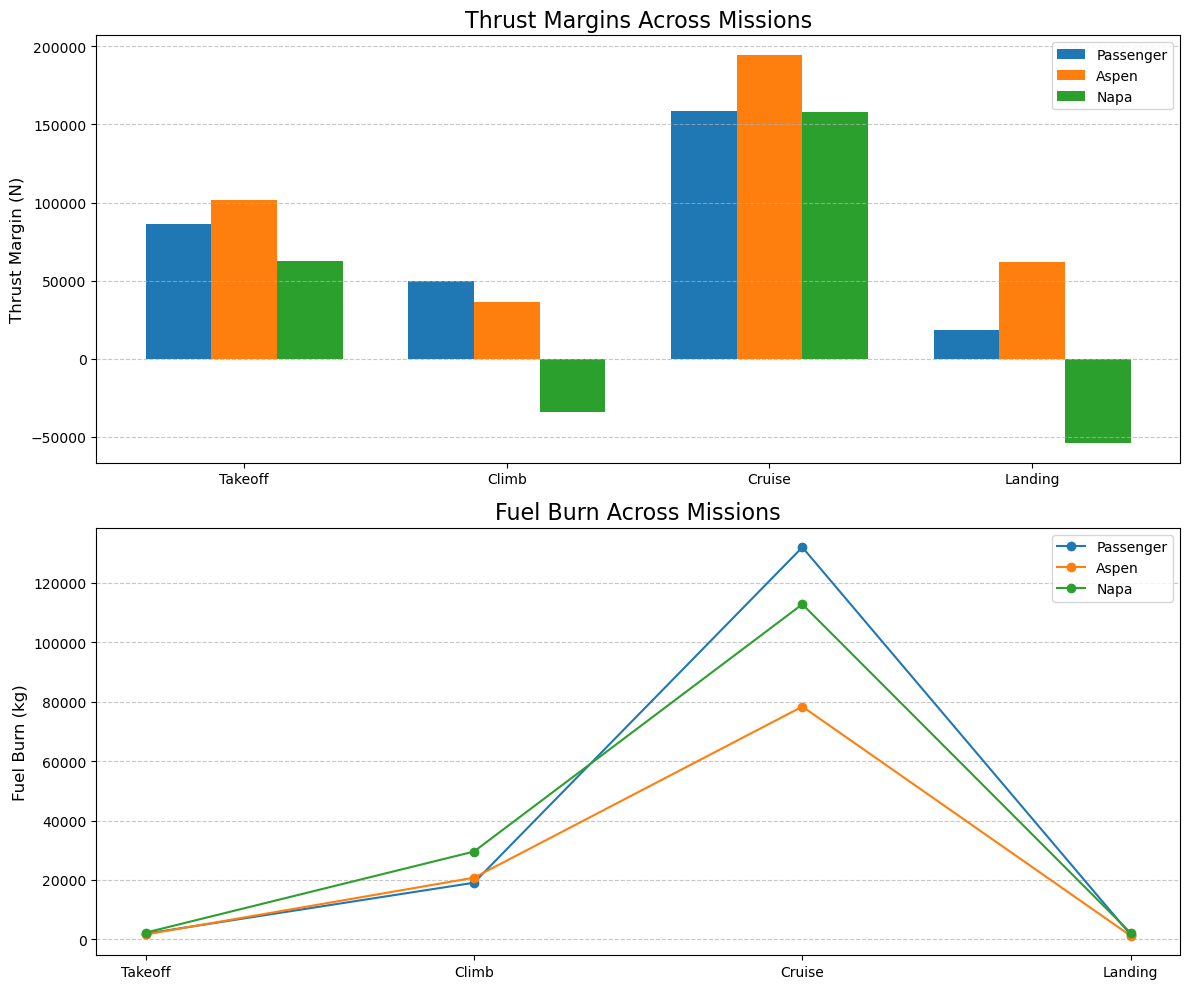

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
T_static_per_engine = 100000  # Static thrust per engine (N)
engines = 2  # Number of engines
T_static_total = T_static_per_engine * engines  # Total available thrust (N)
T0 = 288.15  # Standard temperature (K)
rho_sl = 1.225  # Sea level air density (kg/m³)
TSFC_static = 0.00014  # Static TSFC (kg/N/s)
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Mission-specific inputs
missions = {
    "Passenger": {
        "altitude": [0, 5000, 12500, 0],
        "speeds": [70, 140, 250, 60],
        "temperatures": [288.15, 281.65, 268.15, 288.15],
        "thrust_required": [113828.41, 154825.52, 56258.21, 181802.25],
        "durations": [120, 900, 18000, 60]
    },
    "Aspen": {
        "altitude": [0, 2500, 11000, 0],
        "speeds": [65, 130, 230, 55],
        "temperatures": [288.15, 281.15, 250.15, 268.15],
        "thrust_required": [98147.96, 168816.91, 35801.06, 152764.39],
        "durations": [120, 900, 18000, 60]
    },
    "Napa": {
        "altitude": [0, 2000, 10000, 0],
        "speeds": [75, 150, 240, 70],
        "temperatures": [298.15, 293.15, 283.15, 298.15],
        "thrust_required": [130670.37, 230555.95, 45534.47, 247453.06],
        "durations": [120, 900, 18000, 60]
    },
}

# Results storage
thrust_margins = {mission: [] for mission in missions}
fuel_burns = {mission: [] for mission in missions}

# Perform calculations
for mission, data in missions.items():
    print(f"Mission: {mission}")
    thrust_required = data["thrust_required"]
    temperatures = data["temperatures"]
    durations = data["durations"]

    for i, phase in enumerate(phases):
        # Correct available thrust for temperature
        T_corrected = T_static_total * T0 / temperatures[i]
        
        # Calculate thrust margin
        margin = T_corrected - thrust_required[i]
        thrust_margins[mission].append(margin)
        
        # Calculate fuel burn
        TSFC_corrected = TSFC_static * (temperatures[i] / T0)  # Adjust TSFC
        fuel_burn = TSFC_corrected * thrust_required[i] * durations[i]
        fuel_burns[mission].append(fuel_burn)

        print(f"{phase}:")
        print(f"  Corrected Thrust: {T_corrected:.2f} N")
        print(f"  Thrust Margin: {margin:.2f} N")
        print(f"  Fuel Burn: {fuel_burn:.2f} kg")

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Bar plot for thrust margins
x = np.arange(len(phases))
width = 0.25
for i, mission in enumerate(missions):
    axs[0].bar(x + i * width, thrust_margins[mission], width, label=mission)
axs[0].set_title("Thrust Margins Across Missions", fontsize=16)
axs[0].set_ylabel("Thrust Margin (N)", fontsize=12)
axs[0].set_xticks(x + width)
axs[0].set_xticklabels(phases)
axs[0].legend(fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Line plot for fuel burns
for mission in missions:
    axs[1].plot(phases, fuel_burns[mission], marker='o', label=mission)
axs[1].set_title("Fuel Burn Across Missions", fontsize=16)
axs[1].set_ylabel("Fuel Burn (kg)", fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


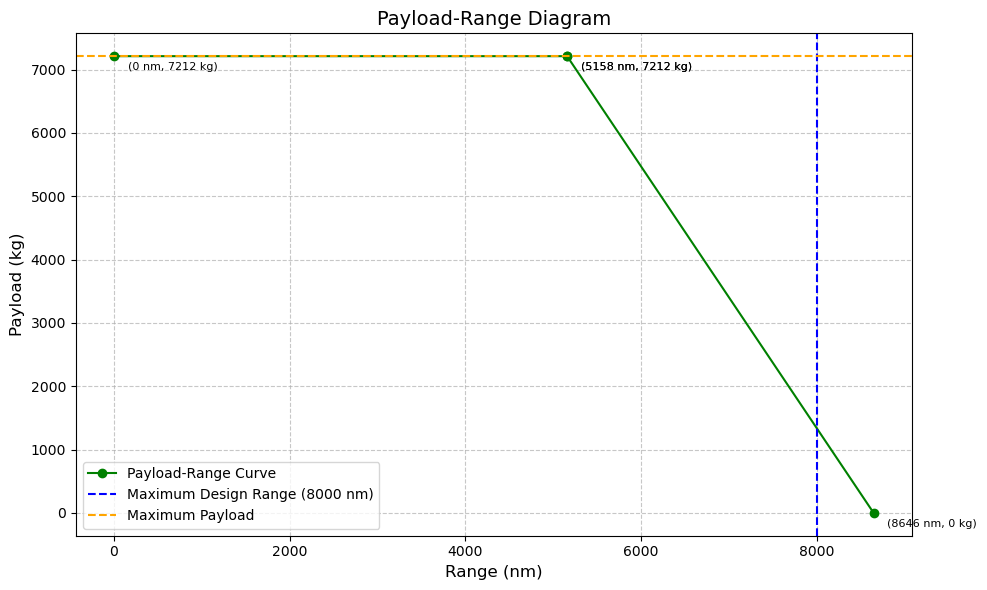

In [5]:
# Constants and inputs based on the user's design and the provided document
import numpy as np
import matplotlib.pyplot as plt

# Aircraft-specific parameters
mtow_lb = 106000  # Maximum takeoff weight in lbs
mtow_kg = mtow_lb * 0.453592  # Convert to kg
oew_fraction = 0.55  # Operating empty weight as fraction of MTOW
fuel_fraction = 0.30  # Fuel weight as fraction of MTOW
oew_kg = mtow_kg * oew_fraction  # Operational empty weight in kg
fuel_weight_kg = mtow_kg * fuel_fraction  # Maximum fuel weight in kg
max_payload_kg = mtow_kg - oew_kg - fuel_weight_kg  # Maximum payload

# Flight performance parameters
V = 250  # Cruise speed (m/s)
TSFC = 0.00014  # Thrust specific fuel consumption (1/s)
LD_ratio = 15  # Lift-to-drag ratio

# Key points in payload-range diagram
R_nm = []  # Ranges in nautical miles
Payload_kg = []  # Payloads in kg

# Point A: Max payload, zero range
R_nm.append(0)
Payload_kg.append(max_payload_kg)

# Point B: Max payload, max range (using Breguet equation)
W1_B = mtow_kg
W2_B = W1_B - fuel_weight_kg  # Remaining weight after burning all fuel
range_B = (V / TSFC) * LD_ratio * np.log(W1_B / W2_B) / 1852  # Convert to nautical miles
R_nm.append(range_B)
Payload_kg.append(max_payload_kg)

# Point C: Max fuel, reduced payload
fuel_available = fuel_weight_kg
payload_C = mtow_kg - oew_kg - fuel_available
W1_C = mtow_kg
W2_C = oew_kg + payload_C  # Remaining weight after burning fuel
range_C = (V / TSFC) * LD_ratio * np.log(W1_C / W2_C) / 1852  # Convert to nautical miles
R_nm.append(range_C)
Payload_kg.append(payload_C)

# Point D: Ferry range (zero payload)
W1_D = mtow_kg
W2_D = oew_kg  # Only OEW remains
range_D = (V / TSFC) * LD_ratio * np.log(W1_D / W2_D) / 1852  # Convert to nautical miles
R_nm.append(range_D)
Payload_kg.append(0)

# Plotting the payload-range diagram
plt.figure(figsize=(10, 6))
plt.plot(R_nm, Payload_kg, marker='o', color='green', label='Payload-Range Curve')
plt.axvline(x=8000, linestyle="--", color="blue", label="Maximum Design Range (8000 nm)")
plt.axhline(y=max_payload_kg, linestyle="--", color="orange", label="Maximum Payload")

# Annotate key points
for i, (x, y) in enumerate(zip(R_nm, Payload_kg)):
    plt.annotate(f"({int(x)} nm, {int(y)} kg)", (x, y), textcoords="offset points", xytext=(10, -10), fontsize=8)

# Labels and grid
plt.title("Payload-Range Diagram", fontsize=14)
plt.xlabel("Range (nm)", fontsize=12)
plt.ylabel("Payload (kg)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


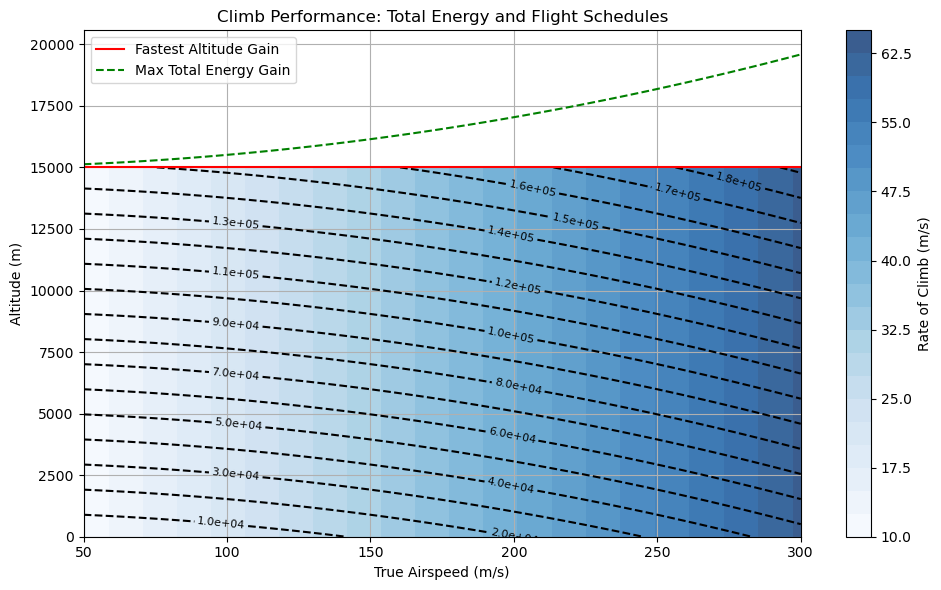

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # Gravitational acceleration (m/s^2)
weight = 471511.32  # Aircraft weight (N)
tas_range = np.linspace(50, 300, 100)  # True Airspeed (m/s)
altitude_range = np.linspace(0, 15000, 100)  # Altitude (m)

# Create meshgrid for plotting
TAS, Altitude = np.meshgrid(tas_range, altitude_range)

# Calculate total energy (kinetic + potential) per unit mass
total_energy = 0.5 * TAS**2 + g * Altitude

# Simplified climb performance limits (replace with real data for your aircraft)
thrust = 100000  # Constant thrust example (N)
drag_coefficient = 0.02  # Simplified drag coefficient
drag = 0.5 * drag_coefficient * TAS**2  # Approximation of drag force
roc = (thrust - drag) / weight * TAS  # Rate of climb (m/s)

# Plot Total Energy Contours
plt.figure(figsize=(10, 6))
cp = plt.contour(TAS, Altitude, total_energy, levels=20, colors="black", linestyles="dashed")
plt.clabel(cp, inline=True, fontsize=8, fmt="%.1e")
plt.contourf(TAS, Altitude, roc, levels=20, cmap="Blues", alpha=0.8)

# Highlight specific flight schedules (manually or calculated)
fast_alt_gain = np.max(Altitude, axis=0)  # Example for fastest altitude gain
plt.plot(tas_range, fast_alt_gain, "r-", label="Fastest Altitude Gain")

max_total_energy = np.max(total_energy, axis=0)  # Example for max total energy
plt.plot(tas_range, max_total_energy / g, "g--", label="Max Total Energy Gain")

# Labels and Legends
plt.title("Climb Performance: Total Energy and Flight Schedules")
plt.xlabel("True Airspeed (m/s)")
plt.ylabel("Altitude (m)")
plt.legend()
plt.colorbar(label="Rate of Climb (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()
